In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Naive image anomaly detection on Fashion MNIST with Euclidean and Riemannian means, distances, and norms

The goal of this notebook is to evaluate to possibility to achieve anomaly detection in image databases with naive distances to centroids and norms using Euclidean and Riemannian representations. The methods considered being rudimentary, only simple AD setups where the objective is to discriminate between two classes of the Fashion MNIST dataset will be considered. A general approach to embed images into the space of covariance matrices is introduced.

**Authors:** Martin Bauw, Santiago Velasco-Forero, Jesus Angulo 

**Table of contents:**

---

[1. Introduction and motivation](#intro)

[1.1. Experiments hyperparameters](#intro1)

---

[2. Analysis/Experiment](#analysis)

[2.1. Dataset loading](#analysis1)

[2.2. Dataset description and preprocessing into covariance matrices](#analysis2)

[2.3. AD with Riemannian distance to Fréchet mean](#analysis3)

[2.4. AD with norm of negated geodesic PCA](#analysis4)

[2.5. AD with norm of negated geodesic PCA with Giotto-TDA preprocessing](#analysis5)

[2.6. Role of Geomstats/Giotto-TDA in the analysis](#analysis6)

---

[3. Benchmark](#benchmark)

[3.1. Euclidean baseline: distance to Euclidean mean](#benchmark1)

[3.2. Euclidean baseline: distance to Euclidean mean after PCA](#benchmark2)

[3.3. Euclidean baseline: Mahalanobis distance to Euclidean mean](#benchmark3)

[3.4. Euclidean baseline: Mahalanobis distance to Euclidean mean after PCA](#benchmark4)

[3.5. Euclidean baseline: norm negated PCA](#benchmark5)

[3.6. Results comparison](#benchmark6)

---

[4. Limitations and perspectives](#limitations)

---

[5. References](#references)

---

In [2]:
# tensorflow not amongst Geomstats’ and Giotto-tda’s requirements.txt
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install giotto-tda-nightly

  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.3
    Uninstalling scipy-1.6.3:
      Successfully uninstalled scipy-1.6.3
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

giotto-tda 0.4.0 requires scipy>=1.5.0, but you'll have scipy 1.4.1 which is incompatible.
giotto-tda-nightly 20210113.12 requires scipy>=1.5.0, but you'll have scipy 1.4.1 which is incompatible.
geomstats 2.2.2 requires joblib==0.14.1, but you'll have joblib 1.0.1 which is incompatible.
  Using cached scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl (27.4 MB)


  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.2.0 requires scipy==1.4.1; python_version >= "3", but you'll have scipy 1.6.3 which is incompatible.
geomstats 2.2.2 requires joblib==0.14.1, but you'll have joblib 1.0.1 which is incompatible.


In [3]:
import geomstats.backend as gs
from geomstats.learning.kmeans import RiemannianKMeans
import geomstats.geometry.spd_matrices as spd
from geomstats.learning.kmeans import FrechetMean
from geomstats.learning.pca import TangentPCA

from sklearn.metrics import roc_auc_score
from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA

from gtda.images import RadialFiltration
from gtda.images import DilationFiltration
from gtda.images import ErosionFiltration
from gtda.images import DensityFiltration
from gtda.images import Binarizer

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# make sure tensorflow doesn't use GPU to avoid problem of insufficient GPU memory to handle batch size
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

INFO: Using numpy backend


# <a id='intro'>1. Introduction and motivation</a>

<div style="text-align: justify">
Anomaly detection (AD) in images is a useful tool in a large variety of applications. One can detect anomalies on images to raise an alarm in video surveillance, or to identify flaws for quality control. This AD problem is an active research subject in the machine learning and data processing community. The main difference between AD and classification lies in the supervision and the information available during training. Whereas classification requires representative training data for each mode, AD gathers a single or a set of classes in a unique normal mode and separates the latter from any different data. In order to do this, so-called unsupervised AD only uses normal samples during training to characterize the normality latent distribution, whereas semi-supervised AD additionally takes into account a minority of labelled anomalies to learn the latent boundary. AD remains a difficult task when normality is complex, e.g. multimodal, or when the data provided that defines the latent distribution of normality is not representative, which could lead to a latent boundary easily excluding normal samples in the test phase. Other typical difficulties include potentially infinite diversity when it comes to anomalies and excessive similarity between some normal samples and some anomalies. The following image illustrates what a generic AD setup looks like.
</div>

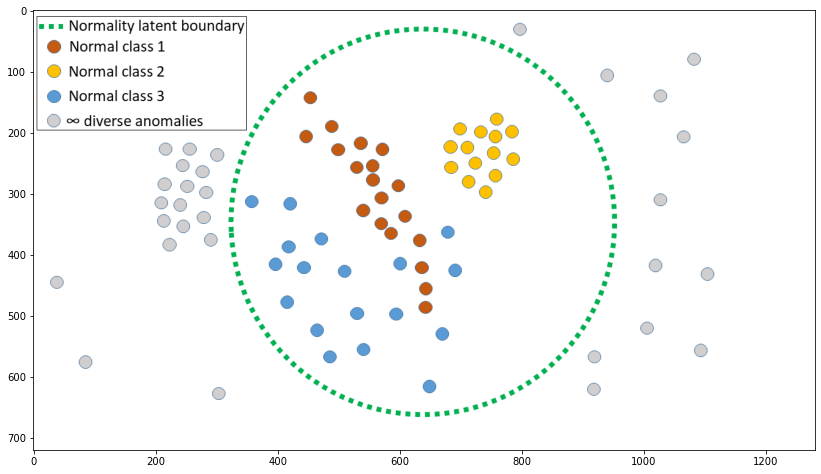

In [4]:
# show image with python to avoid github error when displaying notebook in browser without jupyter
plt.figure(figsize=(14,9))
plt.imshow(mpimg.imread('multimodal_AD.png'))

<div style="text-align: justify">
In this notebook, we explore the performances of naive AD methods with simple distances and norms directly in representation space or after a PCA dimensionality reduction. The objective is to check where naive approaches stand with respect to the very simple AD task of separating two modes of data, i.e. normality is not multimodal and abnormality is not infinitely diverse. This amounts to discriminating between two classes with training data available only for one of the two. The dataset chosen for this experiment is Fashion MNIST. This choice is motivated by the will to practice on a simple enough dataset, avoiding the complexity of CIFAR10 and the lack of multiscale structure in MNIST.
</div>

<br>

<div style="text-align: justify">
Working on distance to centroids and norms asks the question of the representation space on which to compute those features. Following recent research putting forward the relevance of SPD matrices representations, the images will first be transformed into covariance matrices. This enables us to compare the performances of means and distances either defined in an Euclidean setting or a Riemannian setting, the Riemannian setting being provided by the SPD manifold. The Riemannian tools carry the hope that a well chosen manifold makes the distances between samples more relevant with respect to the AD task considered. This translates into the idea that a well chosen manifold is a manifold more adapted to the data distribution.
</div>

<br>

<div style="text-align: justify">
The next figure represents the AD pipelines considered in this notebook, with each notebook subsection implementing the corresponding method indicated on the left.
</div>

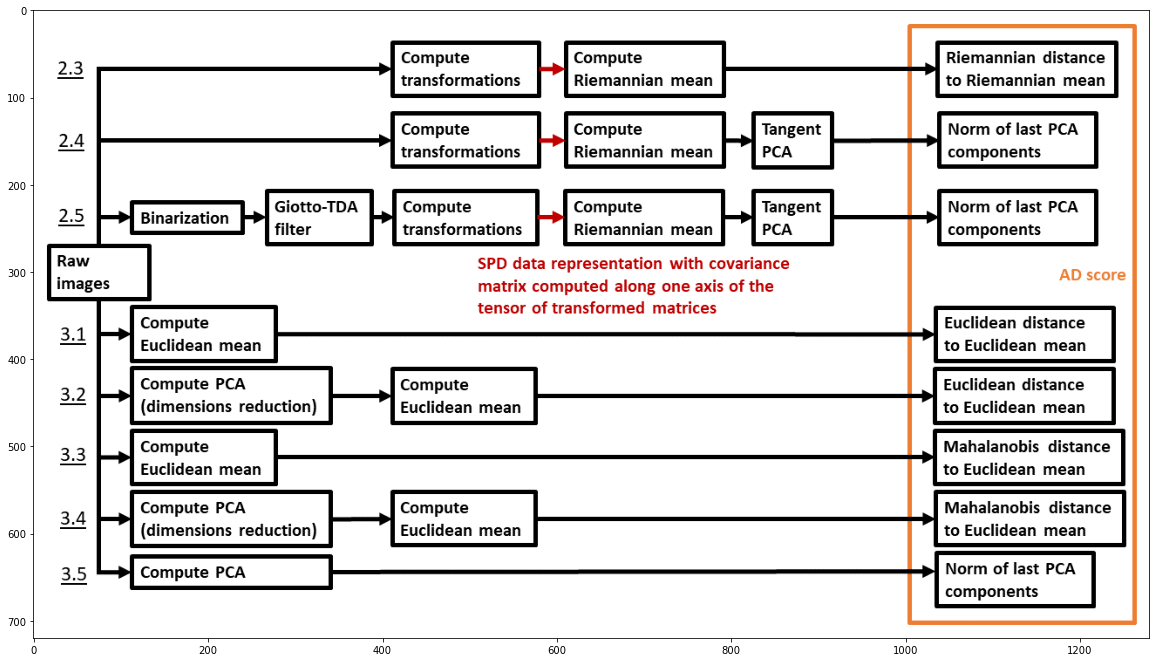

In [5]:
# show image with python to avoid github error when displaying notebook in browser without jupyter
plt.figure(figsize=(20,13))
plt.imshow(mpimg.imread('ICLR2021_geomstatsChallenge_pipelines.png'))

## <a id='intro1'>1.1. Experiments hyperparameters</a> 

In [6]:
results_dic = {}

Choice of the Fashion MNIST classes we will separate, we choose 0 (T-shirt) and 2 (Pullover) to obtain a difficult separation problem, since these two classes are quite similar:

In [7]:
class1 = 0
class2 = 2

Choice of the number of samples available to compute the mean, defining the normality centroid or reference point:

In [8]:
nsamples = 1000

Choice of the covariance matrix type:

In [9]:
cov_type = 'siegel2'

Choice of the image axis along which the covariance matrix will be computed:

In [10]:
axis_to_cov = 2

Choice of the Giotto-TDA preprocessing filter, and of the binarization threshold for the binarization preceding the filter:

In [11]:
# gfiltertype = 'density'
# gfiltertype = 'dilation'
# gfiltertype = 'erosion'
gfiltertype = 'radial'

binarize_threshold = 0.4

Choice of the number of components for PCA:

In [12]:
n_components_PCA = 20

# <a id='analysis'>2. Analysis/Experiment</a>

## <a id='analysis1'>2.1. Dataset loading</a> 

The so-called normal class seen during training in the unsupersived AD setup is class1, defined in the hyperparameters. The other class, which we try to separate from class1 will only be seen in test.

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train/255.
x_test = x_test/255.

filter_class = y_train==class1

x_train1 = x_train[filter_class,:,:]
y_train1 = y_train[filter_class]
x_train1 = x_train1[0:nsamples,:,:]
x_train1 = np.expand_dims(x_train1,axis=-1)

filter_class = y_test==class1
x_test1 = x_test[filter_class]
x_test1 = np.expand_dims(x_test1,axis=-1)

filter_class = y_test==class2
x_test2 = x_test[filter_class]
x_test2 = np.expand_dims(x_test2,axis=-1)

## <a id='analysis2'>2.2. Dataset description and preprocessing into covariance matrices</a> 

To obtain a relevant SPD matrix to describe an image, transformations of the image will be accumulated, the resulting tensor will be reshaped according to the chosen covariance matrix axis in the hyperparameters, and finally the covariance matrix will be computed. To make this SPD as much relevant as possible, the append mean approach is considered, in order to associate the two first orders representations in the SPD matrix. It can be interpreted as the Riemannian space of non-centered multivariate Gaussian distributions, which has a geometry described by the Siegel metric [[1]](#[1]).

In [14]:
def compute_transformation(x_train):
    x_train=x_train+(np.random.random(x_train.shape)/100)
    xout=[]
    xout.append(x_train)
    for i in range(-3,4,2):
        xtemp=tf.roll(x_train,i,axis=1)
        for j in range(-3,4,2):
            xout.append(tf.roll(xtemp,j,axis=2))
    xout.append(tf.image.flip_left_right(x_train))
    xout.append(tf.image.flip_up_down(x_train))
    xout.append(tf.image.rot90(x_train))
    xout.append(tf.image.rot90(x_train,k=2))
    xout.append(tf.image.rot90(x_train,k=3))
    xout=np.stack(xout,axis=-1)
    return xout

In [15]:
def reshape_byaxis(xout,axis=1):
    xout=np.swapaxes(xout,axis,-1)
    return np.reshape(xout,[xout.shape[0],xout.shape[1]*xout.shape[2]*xout.shape[3],xout.shape[4]])

In the following function, three possible SPD representations can be computed: a covariance matrix, or two append mean SPD representations combining first and second order moments. As indicated in the code comments, these two append mean approaches stem from the literature [[1]](#[1]) [[2]](#[2]).

<br>

Append mean approach SPD representation with "siegel" option for **compute_cov()** (cf. next notebook cell):

<br>

\begin{equation}
\begin{pmatrix}
\Sigma+ \beta^2 \mu \mu^T & \beta \mu \\
\beta \mu^T & 1
\end{pmatrix}
\end{equation}

<br>

Append mean approach SPD representation with "siegel2" option for **compute_cov()** (cf. next notebook cell):

<br>

\begin{equation}
\begin{pmatrix}
\Sigma+ \beta \mu \mu^T & \beta \mu \\
\beta \mu^T & \beta
\end{pmatrix}
\end{equation}

<br>

In the previous equations, beta is a constant, sigma the covariance matrix, and mu the mean vector.

In [16]:
def compute_cov(xout,option='simple'):
    resC=[]
    if option=='simple':
        for i in range(xout.shape[0]):
            C=np.cov(xout[i,:,:].T)
            resC.append(C)
    elif option=='siegel': # append mean from equation 2 here https://arxiv.org/pdf/1703.06817.pdf
        beta=.3 # Constant recommended in https://arxiv.org/pdf/1703.06817.pdf
        for i in range(xout.shape[0]):
            C=np.cov(xout[i,:,:].T)
            m=np.expand_dims(np.mean(xout[i,:,:],axis=0),axis=-1)
            resC.append(np.concatenate([np.concatenate([C+(beta**2)*(m*m.T),beta*m],axis=1),np.concatenate([beta*m,np.ones([1,1])],axis=0).T]))
    elif option=='siegel2': # append mean from lemma 3.1 here https://core.ac.uk/download/pdf/82584625.pdf
        beta=.3 #Constant recommended in https://arxiv.org/pdf/1703.06817.pdf
        for i in range(xout.shape[0]):
            C=np.cov(xout[i,:,:].T)
            m=np.expand_dims(np.mean(xout[i,:,:],axis=0),axis=-1)
            resC.append(np.concatenate([np.concatenate([C+beta*(m*m.T),beta*m],axis=1),np.concatenate([beta*m,beta*np.ones([1,1])],axis=0).T]))
    return np.array(resC)

Text(0.5, 1.0, 'Image transformations accumulated in order to compute \na covariance matrix along the horizontal or vertical axis\n')

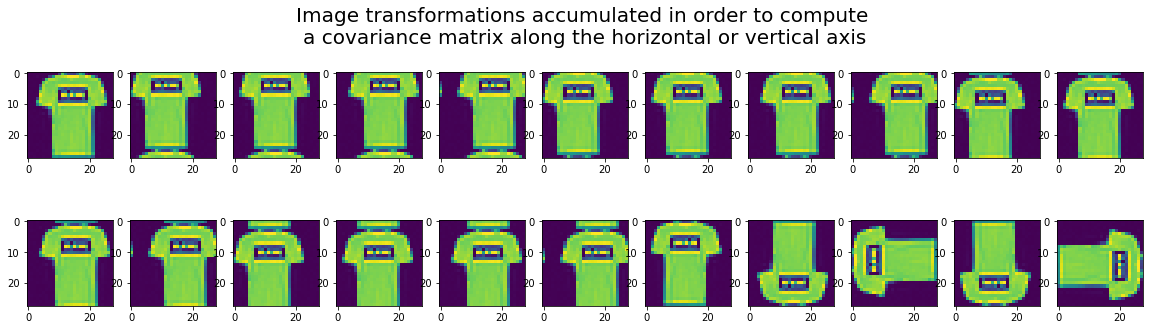

In [17]:
x_train1_transformations = compute_transformation(x_train1)
x_test1_transformations = compute_transformation(x_test1)
x_test2_transformations = compute_transformation(x_test2)

fig, ax = plt.subplots(2,11,figsize=(20,5))
for transf_index1 in range(2):
    for transf_index2 in range(11):
        ax[transf_index1,transf_index2].imshow(x_train1_transformations[0,:,:,0,transf_index2+11*(transf_index1==1)])
ax[0,5].set_title('Image transformations accumulated in order to compute \na covariance matrix along the horizontal or vertical axis\n', fontsize=20)

In [18]:
x_train1_transformations = reshape_byaxis(x_train1_transformations, axis=axis_to_cov)
x_test1_transformations = reshape_byaxis(x_test1_transformations, axis=axis_to_cov)
x_test2_transformations = reshape_byaxis(x_test2_transformations, axis=axis_to_cov)

SPD_train1 = compute_cov(x_train1_transformations, option=cov_type)
SPD_test1 = compute_cov(x_test1_transformations, option=cov_type)
SPD_test2 = compute_cov(x_test2_transformations, option=cov_type)

Text(0.5, 1.0, 'SPD representation of the image \n(notice the append mean approach illuminating the last column & row)')

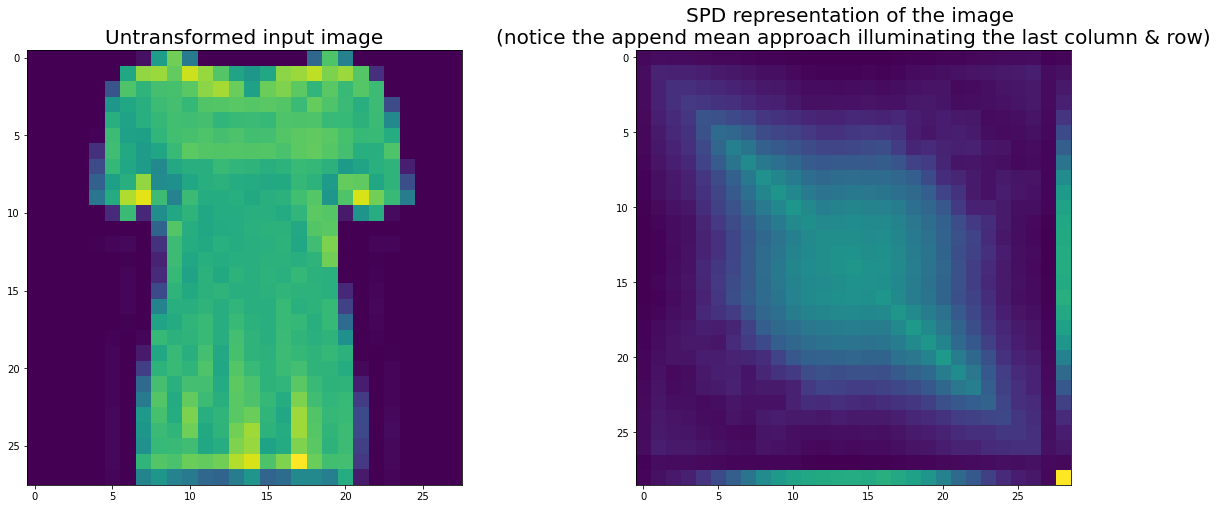

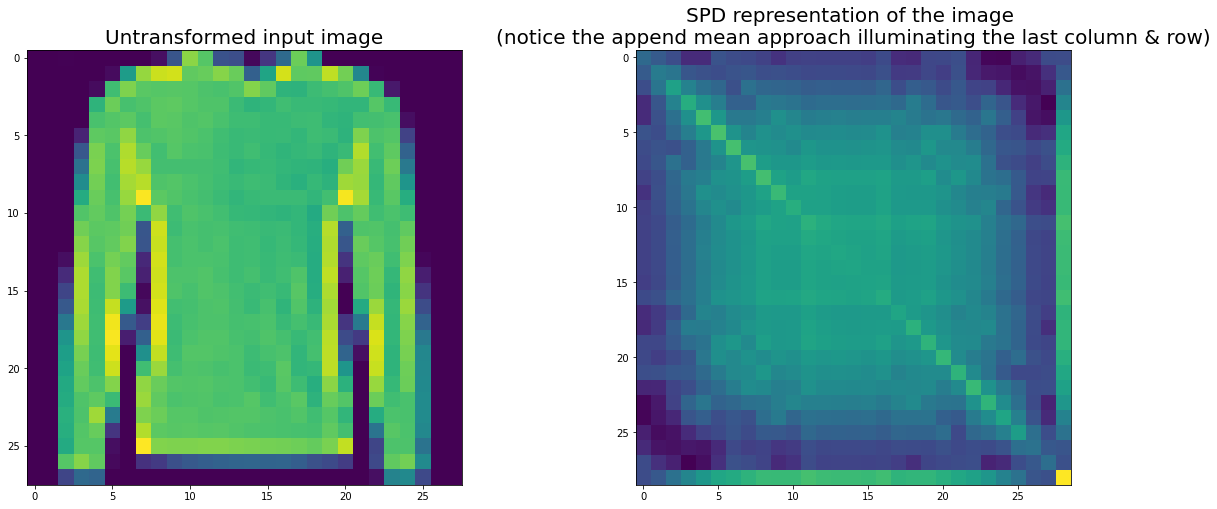

In [19]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].imshow(x_train1[3])
ax[0].set_title('Untransformed input image', fontsize=20)
ax[1].imshow(SPD_train1[3])
ax[1].set_title('SPD representation of the image \n(notice the append mean approach illuminating the last column & row)', fontsize=20)

fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].imshow(x_test2[7])
ax[0].set_title('Untransformed input image', fontsize=20)
ax[1].imshow(SPD_test2[7])
ax[1].set_title('SPD representation of the image \n(notice the append mean approach illuminating the last column & row)', fontsize=20)

## <a id='analysis3'>2.3. AD with Riemannian distance to Fréchet mean</a> 

A Riemannian metric must be chosen among those available in Geomstats, in order to compute the Fréchet mean and the distance to this mean

In [20]:
dim = SPD_train1[0].shape[1]
# riem_metric = spd.SPDMetricAffine(dim)
riem_metric = spd.SPDMetricLogEuclidean(dim)

Compute Fréchet SPD matrices mean according to previously chosen SPD metric:

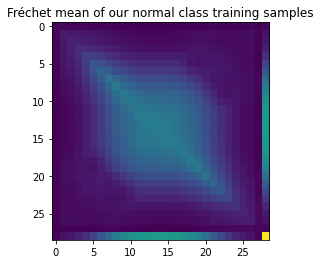

In [21]:
FM = FrechetMean(riem_metric).fit(SPD_train1)

plt.imshow(FM.estimate_)
plt.title('Fréchet mean of our normal class training samples')
plt.show()

Compute distances of test samples to Fréchet mean:

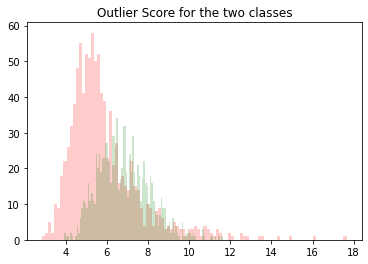

In [22]:
riemdist_test1 = riem_metric.dist(FM.estimate_,np.array(SPD_test1))
plt.hist(riemdist_test1, alpha=0.2, color='r', bins=100)

riemdist_test2 = riem_metric.dist(FM.estimate_,np.array(SPD_test2))
plt.hist(riemdist_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for the two classes')
plt.show()

ROC AUC achieved:

In [23]:
print(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([riemdist_test1, riemdist_test2])))

0.7279720000000001


In [24]:
results_dic['dist_frechet_mean'] = roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([riemdist_test1, riemdist_test2]))

## <a id='analysis4'>2.4. AD with norm of negated geodesic PCA</a> 

Use norm of negated geodesic PCA as detector [[3]](#[3]), with the previously computed Riemannian mean as PCA base point:

In [25]:
tpca = TangentPCA(metric=riem_metric, n_components=n_components_PCA)
tpca = tpca.fit(SPD_train1, base_point=FM.estimate_)

tangent_projected_data_test1 = tpca.transform(SPD_test1)
tangent_projected_data_test2 = tpca.transform(SPD_test2)

In [26]:
scores = []
for var in range(0,19):
    scores.append(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([np.sum(tangent_projected_data_test1[:,var:]**2,axis=1),np.sum(tangent_projected_data_test2[:,var:]**2,axis=1)])))

print("Best ROC AUC is: {} for norm of {} last PCA dimensions".format(max(scores), 20-scores.index(max(scores))))

Best ROC AUC is: 0.8808370000000001 for norm of 14 last PCA dimensions


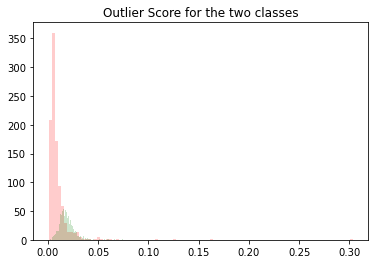

In [27]:
negPCAscore_test1 = np.sum(tangent_projected_data_test1[:,scores.index(max(scores)):]**2,axis=1)
plt.hist(negPCAscore_test1, alpha=0.2, color='r', bins=100)

negPCAscore_test2 = np.sum(tangent_projected_data_test2[:,scores.index(max(scores)):]**2,axis=1)
plt.hist(negPCAscore_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for the two classes')
plt.show()

In [28]:
results_dic['negated geodesic PCA'] = max(scores)

## <a id='analysis5'>2.5. AD with norm of negated geodesic PCA with Giotto-TDA preprocessing</a> 

In [29]:
class giotto_preprocessing():
    def __init__(self, x_train, filter_name):
        self.filter_name = filter_name
        if self.filter_name == 'dilation':
            self.filter = DilationFiltration()
        elif self.filter_name == 'erosion':
            self.filter = ErosionFiltration()
        elif self.filter_name == 'density':
            self.filter = DensityFiltration()
        elif self.filter_name == 'radial':
            self.filter = RadialFiltration()
        else: 
            raise NoValidGiottoFilterError
        self.filter.fit(x_train)
        
    def transform(self, x):
        return self.filter.transform(x)

Binarize data to be able to apply Giotto-TDA filter:

In [30]:
binarizer = Binarizer(threshold=binarize_threshold)    
x_train1 = binarizer.fit_transform(x_train1)

x_test1 = binarizer.transform(x_test1)
x_test2 = binarizer.transform(x_test2)

Define Giotto-TDA filter:

In [31]:
gfilter = giotto_preprocessing(x_train1, gfiltertype)

Transform train and test data with Giotto-TDA filter and compute new SPD representations:

In [32]:
x_train1_filtered = gfilter.transform(x_train1)

x_test1_filtered = gfilter.transform(x_test1)
x_test2_filtered = gfilter.transform(x_test2)

In [33]:
x_train1_transformations_filtered = compute_transformation(x_train1_filtered)
x_test1_transformations_filtered = compute_transformation(x_test1_filtered)
x_test2_transformations_filtered = compute_transformation(x_test2_filtered)

x_train1_transformations_filtered = reshape_byaxis(x_train1_transformations_filtered, axis=axis_to_cov)
x_test1_transformations_filtered = reshape_byaxis(x_test1_transformations_filtered, axis=axis_to_cov)
x_test2_transformations_filtered = reshape_byaxis(x_test2_transformations_filtered, axis=axis_to_cov)

SPD_train1_filtered = compute_cov(x_train1_transformations_filtered, option=cov_type)
SPD_test1_filtered = compute_cov(x_test1_transformations_filtered, option=cov_type)
SPD_test2_filtered = compute_cov(x_test2_transformations_filtered, option=cov_type)

Text(0.5, 1.0, 'SPD representation of the filtered image')

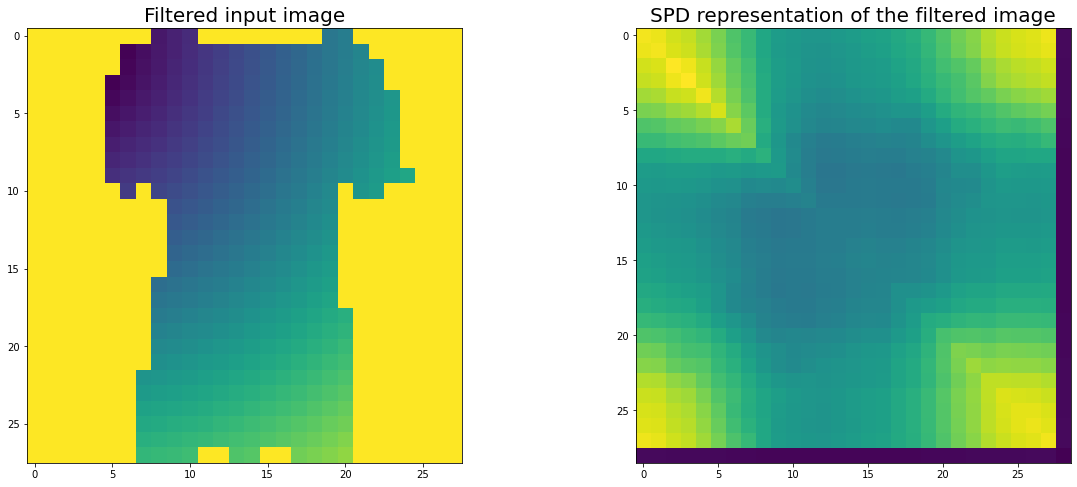

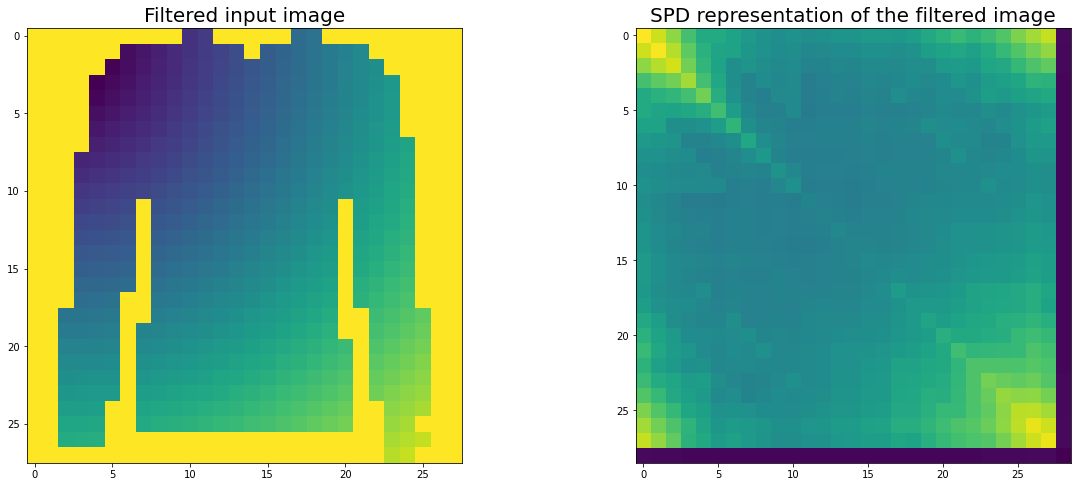

In [34]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].imshow(x_train1_filtered[3])
ax[0].set_title('Filtered input image', fontsize=20)
ax[1].imshow(SPD_train1_filtered[3])
ax[1].set_title('SPD representation of the filtered image', fontsize=20)

fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].imshow(x_test2_filtered[7])
ax[0].set_title('Filtered input image', fontsize=20)
ax[1].imshow(SPD_test2_filtered[7])
ax[1].set_title('SPD representation of the filtered image', fontsize=20)

A new Riemannian mean needs to be computed in order to compute the PCA base point:

In [35]:
dim = SPD_train1_filtered[0].shape[1]
# riem_metric = spd.SPDMetricAffine(dim)
riem_metric = spd.SPDMetricLogEuclidean(dim)

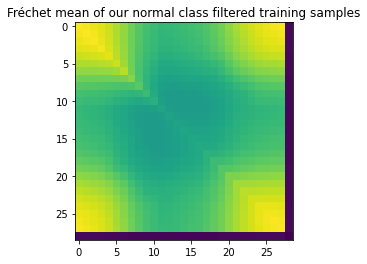

In [36]:
FM = FrechetMean(riem_metric).fit(SPD_train1_filtered)
FM.estimate_

plt.imshow(FM.estimate_)
plt.title('Fréchet mean of our normal class filtered training samples')
plt.show()

In [37]:
tpca = TangentPCA(metric=riem_metric, n_components=n_components_PCA)
tpca = tpca.fit(SPD_train1_filtered, base_point=FM.estimate_)

tangent_projected_fdata_test1 = tpca.transform(SPD_test1_filtered)
tangent_projected_fdata_test2 = tpca.transform(SPD_test2_filtered)

In [38]:
scores = []
for var in range(0,19):
    scores.append(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1_filtered)),np.ones(len(SPD_test1_filtered))]),np.concatenate([np.sum(tangent_projected_fdata_test1[:,var:]**2,axis=1),np.sum(tangent_projected_fdata_test2[:,var:]**2,axis=1)])))

print("Best ROC AUC is: {} for norm of {} last PCA dimensions".format(max(scores), 20-scores.index(max(scores))))

Best ROC AUC is: 0.887529 for norm of 13 last PCA dimensions


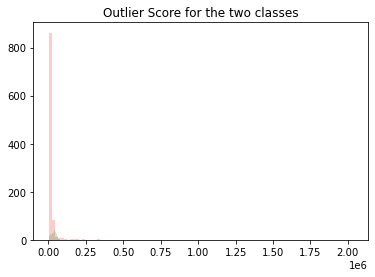

In [39]:
negPCAscore_test1 = np.sum(tangent_projected_fdata_test1[:,scores.index(max(scores)):]**2,axis=1)
plt.hist(negPCAscore_test1, alpha=0.2, color='r', bins=100)

negPCAscore_test2 = np.sum(tangent_projected_fdata_test2[:,scores.index(max(scores)):]**2,axis=1)
plt.hist(negPCAscore_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for the two classes')
plt.show()

In [40]:
results_dic['negated geodesic PCA with preprocessing filter'] = max(scores)

## <a id='analysis6'>2.6. Role of Geomstats/Giotto-TDA in the analysis</a> 

<div style="text-align: justify">
The package geomstats allows the AD naive approach, i.e. the distance to the normality reference centroid, to be tested on the SPD manifold on which the data points are projected. The library realizes the most important computations in our experiments, which are the computations of a Riemannian mean and of a Riemannian distance. It also allows us to consider another AD naive approach, i.e. the one where the norm of the last PCA components constitutes an AD score, with its TangentPCA() function, which takes into account the manifold constraint. Finally, Giotto-TDA provides us with a useful preprocessing filter which leads to an improvement in the AD performances.
</div>

# <a id='benchmark'>3. Benchmark</a> 

In [41]:
class EuclideanMetric():
    
    def __init__(self, withMahalanobis=False, train_data=None, pca_reduce=False, n_components=20):
        self.withMahalanobis = withMahalanobis
        self.n_components = n_components
        self.pca_reduce = pca_reduce
        if self.pca_reduce:
            self.pca = PCA(n_components=self.n_components)
        if train_data is None:
            raise NoTrainDataError
        else:
            if self.pca_reduce:
                self.pca = self.pca.fit(train_data.reshape(train_data.shape[0], -1))
            self.centroid = self.init_centroid(train_data)
            if self.withMahalanobis:
                self.empiCov = self.init_Mahalanobis(train_data)
                self.cov = self.empiCov.covariance_
                
    def init_centroid(self, x):
        x = x.reshape(x.shape[0], -1)
        if self.pca_reduce:
            x = self.pca.transform(x)
        return np.sum(x, axis=0)/x.shape[0]
                
    def init_Mahalanobis(self, x):
        x = x.reshape(x.shape[0], -1)
        if self.pca_reduce:
            x = self.pca.transform(x)
        
        empiCov = EmpiricalCovariance()
        empiCov.fit(x)
        plt.imshow(empiCov.covariance_)
        plt.title('Mahalanobis Covariance Matrix')
        plt.show()
        return empiCov

    def dist_to_centroid(self, test_data):
        if self.withMahalanobis:
            return self.Mahalanobis(test_data)
        else:
            return self.Frobenius(test_data)
    
    def Frobenius(self, x):
        x = x.reshape(x.shape[0], -1)
        if self.pca_reduce:
            x = self.pca.transform(x)
        return np.sqrt(np.sum((np.subtract(x, self.centroid))**2, axis=1))
    
    def Mahalanobis(self, x):
        x = x.reshape(x.shape[0], -1)
        if self.pca_reduce:
            x = self.pca.transform(x)
        batch_scores = self.empiCov.mahalanobis(x)
        return np.sqrt(batch_scores)

## <a id='benchmark1'>3.1. Euclidean baseline: distance to Euclidean mean</a> 

In [42]:
baseline_metric = EuclideanMetric(withMahalanobis=False, train_data=SPD_train1, pca_reduce=False)

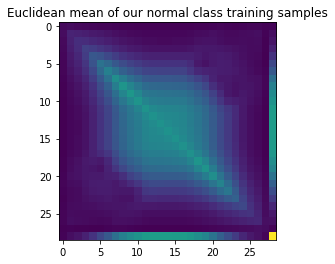

In [43]:
plt.imshow(baseline_metric.centroid.reshape(29,29))
plt.title('Euclidean mean of our normal class training samples')
plt.show()

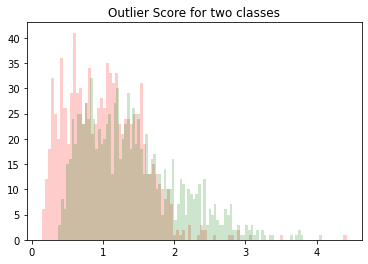

In [44]:
eucldist_test1 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test1))
plt.hist(eucldist_test1, alpha=0.2, color='r', bins=100)

eucldist_test2 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test2))
plt.hist(eucldist_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for two classes')
plt.show()

In [45]:
print(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2])))

0.664795


In [46]:
results_dic['distance to Euclidean mean'] = roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2]))

## <a id='benchmark2'>3.2. Euclidean baseline: distance to Euclidean mean after PCA</a> 

In [47]:
baseline_metric = EuclideanMetric(withMahalanobis=False, train_data=SPD_train1, pca_reduce=True, n_components=n_components_PCA)

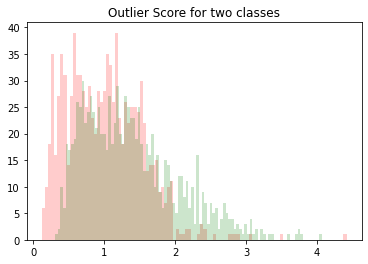

In [48]:
eucldist_test1 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test1))
plt.hist(eucldist_test1, alpha=0.2, color='r', bins=100)

eucldist_test2 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test2))
plt.hist(eucldist_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for two classes')
plt.show()

In [49]:
print(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2])))

0.659112


In [50]:
results_dic['distance to Euclidean mean after PCA'] = roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2]))

## <a id='benchmark3'>3.3. Euclidean baseline: Mahalanobis distance to Euclidean mean</a> 

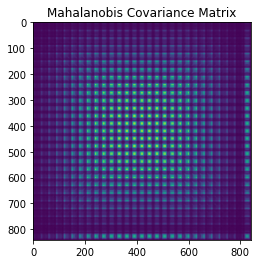

In [51]:
baseline_metric = EuclideanMetric(withMahalanobis=True, train_data=SPD_train1, pca_reduce=False, n_components=n_components_PCA)

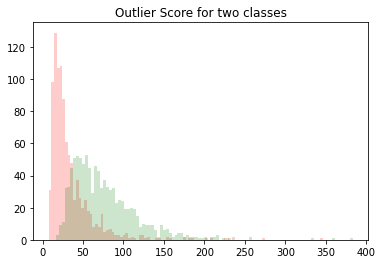

In [52]:
eucldist_test1 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test1))
plt.hist(eucldist_test1, alpha=0.2, color='r', bins=100)

eucldist_test2 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test2))
plt.hist(eucldist_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for two classes')
plt.show()

In [53]:
print(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2])))

0.863534


In [54]:
results_dic['Mahalanobis distance to Euclidean mean'] = roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2]))

## <a id='benchmark4'>3.4. Euclidean baseline: Mahalanobis distance to Euclidean mean after PCA</a> 

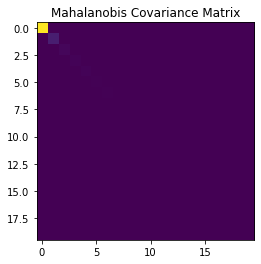

In [55]:
baseline_metric = EuclideanMetric(withMahalanobis=True, train_data=SPD_train1, pca_reduce=True, n_components=n_components_PCA)

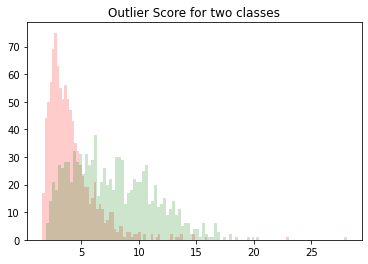

In [56]:
eucldist_test1 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test1))
plt.hist(eucldist_test1, alpha=0.2, color='r', bins=100)

eucldist_test2 = baseline_metric.dist_to_centroid(test_data=np.array(SPD_test2))
plt.hist(eucldist_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for two classes')
plt.show()

In [57]:
print(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2])))

0.8198350000000001


In [58]:
results_dic['Mahalanobis distance to Euclidean mean after PCA'] = roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([eucldist_test1, eucldist_test2]))

## <a id='benchmark5'>3.5. Euclidean baseline: norm negated PCA</a> 

In [59]:
baseline_metric = EuclideanMetric(withMahalanobis=False, train_data=SPD_train1, pca_reduce=True, n_components=n_components_PCA)

In [60]:
tangent_projected_data_test1 = baseline_metric.pca.transform(SPD_test1.reshape(SPD_test1.shape[0], -1))
tangent_projected_data_test2 = baseline_metric.pca.transform(SPD_test2.reshape(SPD_test2.shape[0], -1))

In [61]:
scores = []
for var in range(0,19):
    scores.append(roc_auc_score(np.concatenate([np.zeros(len(SPD_test1)),np.ones(len(SPD_test2))]),np.concatenate([np.sum(tangent_projected_data_test1[:,var:]**2,axis=1),np.sum(tangent_projected_data_test2[:,var:]**2,axis=1)])))

print("Best ROC AUC is: {} for norm of {} last PCA dimensions".format(max(scores), 20-scores.index(max(scores))))

Best ROC AUC is: 0.8371390000000001 for norm of 4 last PCA dimensions


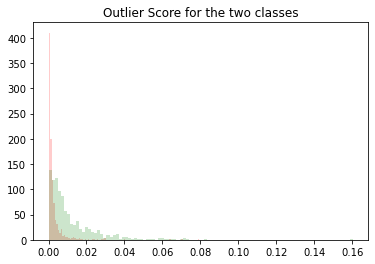

In [62]:
negPCAscore_test1 = np.sum(tangent_projected_data_test1[:,scores.index(max(scores)):]**2,axis=1)
plt.hist(negPCAscore_test1, alpha=0.2, color='r', bins=100)

negPCAscore_test2 = np.sum(tangent_projected_data_test2[:,scores.index(max(scores)):]**2,axis=1)
plt.hist(negPCAscore_test2, alpha=0.2, color='g', bins=100)

plt.title('Outlier Score for the two classes')
plt.show()

In [63]:
results_dic['norm of negated PCA'] = max(scores)

## <a id='benchmark6'>3.6. Results comparison</a> 

In [64]:
print('ROC AUCs of the method considered:')
for key in results_dic:
    print(results_dic[key], '---->', key)

ROC AUCs of the method considered:
0.7279720000000001 ----> dist_frechet_mean
0.8808370000000001 ----> negated geodesic PCA
0.887529 ----> negated geodesic PCA with preprocessing filter
0.664795 ----> distance to Euclidean mean
0.659112 ----> distance to Euclidean mean after PCA
0.863534 ----> Mahalanobis distance to Euclidean mean
0.8198350000000001 ----> Mahalanobis distance to Euclidean mean after PCA
0.8371390000000001 ----> norm of negated PCA


Negated geodesic PCA led to the best ROC AUC performance for the AD task considered. Giotto-TDA preprocessing filter led to a slight performances increase. We also notice the relatively good performances of the Mahalanobis distances in the Euclidean setup.

# <a id='limitations'>4. Limitations and perspectives</a> 

# Limitations of this analysis

<div style="text-align: justify">
In this analysis, we projected data on the SPD manifold hoping for a better understanding of the data latent distribution on this mathematical structure. Good performances were obtained with the naive AD method harnessing the SPD representation, but a final conclusion regarding the absolute relevance of the specific manifold choice can not be reached. In order to reach such a conclusion, one would need to compare the projection of the same problem on a wide variety of manifolds. On the one hand, this camparison would allow to detect the best manifold available if any, on the other hand it would help understand the actual contribution of the manifold chosen here.
</div>

<br>    

<div style="text-align: justify">
Additionally, the AD problem considered, as well as the competing methods implemented, remain naive in its complexity. Although naive, the methods provide in this specific case relatively interesting performances. A study progressively complexifying the AD problem solved would allow to better understand the limits of such naive methods, and the point after which machine learning with, for example, deep neural networks, is actually needed.
</div>

# Limitation of Geomstats and Giotto-TDA



Trainable SPD representations transformations would have allowed to go further in the Euclidean versus Riemannian comparison, enabling the comparison of more complex models.

# Proposed features for Geomstats and Giotto-TDA



<div style="text-align: justify">
Preprocessing dedicated to SPD matrices, or generating a useful SPD representation for various data types would be an interesting contribution to the machine learning on manifolds toolbox. An implementation of a SPD neural network, or so-called second order neural networks, with the Riemannian gradient and much attention given to the efficiency of the gradient computation, would be welcomed since a widely accepted reference code for this promising model has yet to appear. Moreover, such an implementation would enable more subtle comparisons between AD tasks on a variety of manifolds, to take a step back with respect to the Euclidean methods widely used.
</div>

# <a id='references'>5. References</a> 

<a id='[1]'>[1]</a> "A Distance between Multivariate Normal Distributions Based in an Embedding into the Siegel Group" Miquel Calvo and Josep M. Oller

https://core.ac.uk/download/pdf/82584625.pdf

<a id='[2]'>[2]</a> "Second-order Convolutional Neural Networks" Kaicheng Yu and Mathieu Salzmann 

https://arxiv.org/pdf/1703.06817.pdf

<a id='[3]'>[3]</a> "Modeling the Distribution of Normal Data in Pre-Trained Deep Features for Anomaly Detection" Oliver Rippel, Patrick Mertens and Dorit Merhof 

https://arxiv.org/pdf/2005.14140.pdf